In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,vstack
%matplotlib inline
import json
import pandas as pd
import sncosmo
import sys
sys.path.append('/home/mi/Desktop/project-sn-fitter/project')
import sedfit.utils
import sedfit.mangle


In [2]:
example_spectrum = Table.read('example_spectrum',format='ascii')

In [3]:
example_spectrum.colnames

['wavelength', 'flux', 'e_flux']

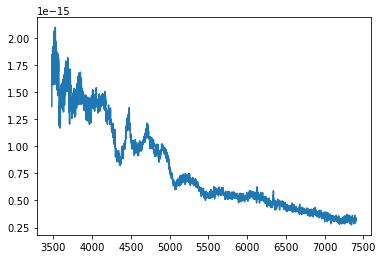

In [4]:
plt.plot(example_spectrum['wavelength'],example_spectrum['flux'])

In [5]:
datafile = 'SN2005hk.json'
data = pd.read_json(datafile)

In [6]:
data = data['SN2005hk']

In [7]:
redshift = float(data['redshift'][0]['value'])
print 'redshift=',redshift

redshift= 0.01306


In [8]:
photometry = pd.read_json(pd.DataFrame(data['photometry']).to_json(),orient='column')

In [9]:
print photometry.columns
photometry.rename(columns={x: x.encode('ascii') for x in photometry.columns})
photometry = Table.from_pandas(photometry)    
photometry['Filter'] = photometry['band']
photometry['Mag'] = photometry['magnitude']
photometry['MagErr'] = photometry['e_magnitude']
photometry['MJD'] = photometry['time']
photometry['Survey'] = photometry['telescope']

Index([u'band', u'bandset', u'e_fluxdensity', u'e_magnitude', u'fluxdensity',
       u'frequency', u'instrument', u'magnitude', u'source', u'system',
       u'telescope', u'time', u'u_fluxdensity', u'u_frequency', u'u_time',
       u'upperlimit', u'upperlimitsigma', u'zeropoint'],
      dtype='object')


In [10]:
phot = photometry['Filter','Mag','MagErr','MJD','Survey','system','source'][~photometry['Mag'].mask]
phot['Survey'][phot['source'] == '11,25'] = 'CfA3'
phot['Survey'][phot['Survey'] == 'PAIRITEL'] = 'CfAIR2'
phot = phot['Filter','Mag','MagErr','MJD','Survey'][~phot['Survey'].mask]
phot['Filter'][phot['Survey']=='SDSS'] = [x[0:1] for x in phot['Filter'][phot['Survey']=='SDSS']]
phot['Filter'][phot['Filter']=='Ks'] = 'K_s'
a1 = phot['Filter']
c = ("-" * len(phot))
a2 = phot['Survey']
phot['Filter'] = map(''.join, zip(a2, c, a1))
phot['Filter'][phot['Survey']=='CfA3'] = [x+'K' for x in phot['Filter'][phot['Survey']=='CfA3']]
phot = phot[~phot['MagErr'].mask]
phot['Survey'] = [str(x) for x in phot['Survey']]

In [11]:
cspdata = Table.read('CSP.dat',format='ascii')
a1 = cspdata['Filter']
c = ("-" * len(cspdata))
a2 = cspdata['Survey']
inst = [x[0:1] for x in cspdata['Instrument']]
cspdata['Filter'] = map(''.join, zip(a2, c, a1,inst))

In [12]:
phot = vstack([phot,cspdata],join_type='inner')

In [13]:
phot.show_in_notebook()

idx,Filter,Mag,MagErr,MJD,Survey
0,SDSS-r,26.301,0.455,53622.344517,SDSS
1,SDSS-r,26.306,0.577,53622.344517,SDSS
2,SDSS-r,23.584,0.871,53627.301597,SDSS
3,CfA3-VK,16.645,0.015,53675.6689,CfA3
4,CfA3-BK,16.612,0.029,53675.6745,CfA3
5,CfA3-VK,16.644,0.009,53675.7334,CfA3
6,CfA3-BK,16.563,0.01,53675.7411,CfA3
7,SDSS-r,16.592,0.004,53676.328754,SDSS
8,SDSS-r,16.598,0.004,53676.328754,SDSS
9,SDSS-i,16.807,0.005,53676.329583,SDSS


In [14]:
spectra = pd.read_json(pd.DataFrame(data['spectra']).to_json(),orient='column')

In [15]:
spectra.columns

Index([u'data', u'filename', u'instrument', u'observer', u'reducer', u'snr',
       u'source', u'time', u'u_errors', u'u_fluxes', u'u_time',
       u'u_wavelengths'],
      dtype='object')

In [16]:
spectra = spectra.sort_values(by=['time'])

In [17]:
spectra['data'][0]

[[u'3480.00', u'1.366944e-15', u'1.8932719e-16'],
 [u'3481.47', u'1.6883218e-15', u'1.9265713e-16'],
 [u'3482.94', u'1.8451346e-15', u'1.9219126e-16'],
 [u'3484.41', u'1.577441e-15', u'1.8965559e-16'],
 [u'3485.88', u'1.7169767e-15', u'1.953534e-16'],
 [u'3487.35', u'1.8165507e-15', u'1.9342538e-16'],
 [u'3488.82', u'1.7250761e-15', u'1.8705049e-16'],
 [u'3490.29', u'1.8846191e-15', u'1.8891832e-16'],
 [u'3491.76', u'1.917305e-15', u'1.8923979e-16'],
 [u'3493.23', u'1.6693629e-15', u'1.8432904e-16'],
 [u'3494.70', u'1.5656345e-15', u'1.8243446e-16'],
 [u'3496.17', u'1.6311012e-15', u'1.8256151e-16'],
 [u'3497.64', u'1.7618112e-15', u'1.8328894e-16'],
 [u'3499.11', u'1.7314572e-15', u'1.8139738e-16'],
 [u'3500.58', u'1.6410006e-15', u'1.7821395e-16'],
 [u'3502.05', u'1.8621837e-15', u'1.8156889e-16'],
 [u'3503.52', u'1.8650071e-15', u'1.8147266e-16'],
 [u'3504.99', u'1.8546623e-15', u'1.8182828e-16'],
 [u'3506.46', u'2.0591697e-15', u'1.8459577e-16'],
 [u'3507.93', u'1.8707322e-15', u'1

In [18]:
set(phot['Survey'])

{'CSP', 'CfA3', 'CfAIR2', 'SDSS', 'Swift'}

In [19]:
# for idx in spectra.index:
#     minwave = pd.read_json(pd.DataFrame(spectra['data'][idx]).to_json())[0].min()
#     maxwave = pd.read_json(pd.DataFrame(spectra['data'][idx]).to_json())[0].max()
#     print spectra['time'][idx],minwave,maxwave

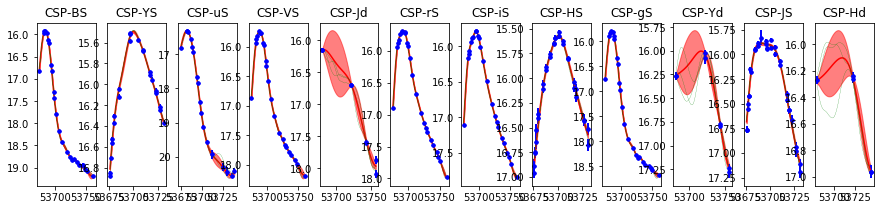

[53684.652947632261, 53699.948393094426, 53682.248286456183, 53687.76583250289, 53683.121985493017, 53691.573672799037, 53694.688805761929, 53700.754729275191, 53685.401013256407, 53716.46519561622, 53690.196393737526, 53709.672149022299]
[u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-VS', u'CSP-Jd', u'CSP-rS', u'CSP-iS', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Effective wavelength of bessellb: 4384.77273446
wavelength difference: -36.0419272146
peakmjd: 53684.6529476


In [20]:
reload(sedfit.utils)

sn = phot[phot['Survey'] == 'CSP'].copy()

z = redshift

sedfit.utils.register_bands_for_sncosmo()

gpfit_result = sedfit.utils.fit_gp(sn)

plt.show()

meanlc = gpfit_result.meanlc
meanlc_err = gpfit_result.meanlc_err
peakmjds = gpfit_result.peakmjds
filters = gpfit_result.filters

print peakmjds
print filters

peakmjd = sedfit.utils.get_b_band_peakmjd(filters,peakmjds,z)
print "peakmjd:", peakmjd
if np.sum(peakmjd>0) == 0:
    print "Can not estimate peak in any band. Stop."


Phase= -9.34095476305
Phase 53675.19 out of data range [53676.0,53731.06].
Phase 53675.19 out of data range [53681.08,53756.07].
Phase 53675.19 out of data range [53676.0,53731.08].
Phase 53675.19 out of data range [53681.08,53756.07].
Phase 53675.19 out of data range [53676.0,53731.08].
Phase 53675.19 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = -9.34095476305
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-9.34095476305 CSP-BS 16.8161487225 7.94988982973e-05      0
-9.34095476305 CSP-gS 16.7452729596 6.27603648087e-05      1
-9.34095476305 CSP-VS 16.8506009564 9.68989560994e-05      2
-9.34095476305 CSP-rS 16.8769819717 7.85468315779e-05      3
modelmag0 [ 16.8780785

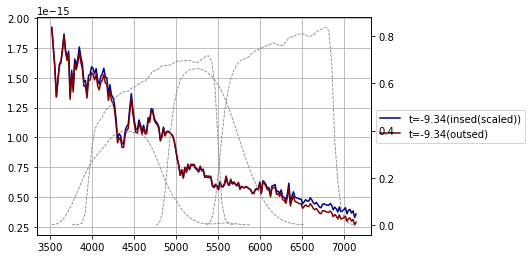

Phase= -8.5413969876
Phase 53676.0 out of data range [53681.08,53756.07].
Phase 53676.0 out of data range [53681.08,53756.07].
Phase 53676.0 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = -8.5413969876
Phot_at_p:
    Phase     Filter      Mag            MagErr      sortid
------------- ------ ------------- ----------------- ------
-8.5413969876 CSP-BS 16.6851844876 0.000198804817613      0
-8.5413969876 CSP-gS 16.6151968545 0.000153376145812      1
-8.5413969876 CSP-VS 16.7186869229 0.000148966004001      2
-8.5413969876 CSP-rS 16.7406957517 0.000122452621384      3
-8.5413969876 CSP-iS  16.954189673 0.000152237690405      4
modelmag0 [ 16.65561743  16.57348518  16.69214549  16.71290434  16.90672715]
phot_at_p['Mag'] - modelmag0: [ 0.0295670

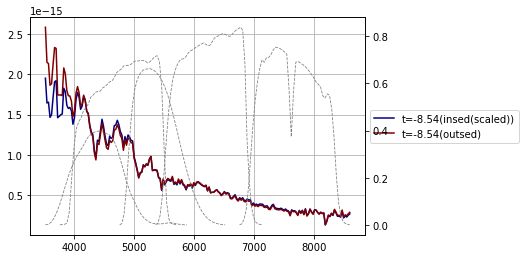

Phase= -8.34397531465
Phase 53676.2 out of data range [53681.08,53756.07].
Phase 53676.2 out of data range [53681.08,53756.07].
Phase 53676.2 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = -8.34397531465
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-8.34397531465 CSP-BS 16.6534433397 0.000247255839782      0
-8.34397531465 CSP-gS 16.5835267626 0.000190063791895      1
-8.34397531465 CSP-VS  16.686417188 0.000173803223921      2
-8.34397531465 CSP-rS 16.7073573805 0.000143186164931      3
-8.34397531465 CSP-iS 16.9216468257 0.000164874800362      4
modelmag0 [-20.66307087 -20.73259389 -20.58791139 -20.53987457 -20.34182   ]
phot_at_p['Mag'] - modelmag0: [ 

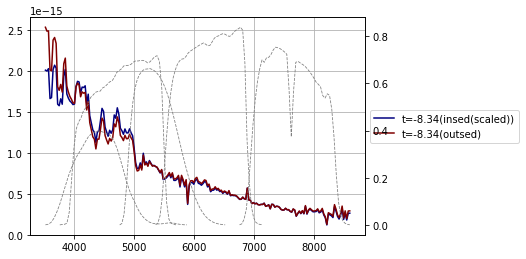

Phase= -8.32423314736
Phase 53676.22 out of data range [53681.08,53756.07].
Phase 53676.22 out of data range [53681.08,53756.07].
Phase 53676.22 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = -8.32423314736
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-8.32423314736 CSP-BS  16.650285183 0.000252197964495      0
-8.32423314736 CSP-gS 16.5803724538 0.000193798119862      1
-8.32423314736 CSP-VS 16.6831998544 0.000176373106262      2
-8.32423314736 CSP-rS 16.7040337116 0.000145329948825      3
modelmag0 [ 16.83957509  16.78412484  16.90800605  16.87291258]
phot_at_p['Mag'] - modelmag0: [-0.18928991 -0.20375239 -0.22480619 -0.16887887]
modelmag: [ 16.61742852  16.56264108 

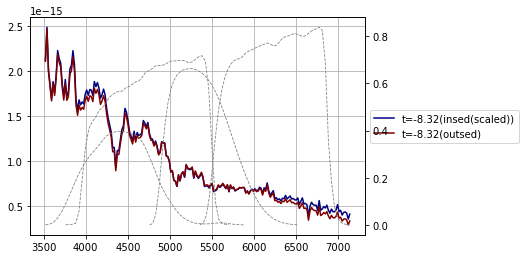

Phase= -7.55428862285
Phase 53677.0 out of data range [53681.08,53756.07].
Phase 53677.0 out of data range [53681.08,53756.07].
Phase 53677.0 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS']
efflam =  [ 5389.26524088  6239.34112913]
Phase = -7.55428862285
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-7.55428862285 CSP-VS 16.5595204668 0.000271294533476      0
-7.55428862285 CSP-rS 16.5763227649 0.000224349762355      1
modelmag0 [ 16.47699095  16.49076718]
phot_at_p['Mag'] - modelmag0: [ 0.08252952  0.08555558]
modelmag: [ 16.55779735  16.57359201]
phot_at_p['Mag'] - modelmag: [ 0.00172311  0.00273076]
diff/err: 12.1718685414
iter = 0
modelmag: [ 16.55944999  16.57620931]
phot_at_p['Mag'] - modelmag: [  7.04733764e-05   1.13450196e-04]
diff/err: 0

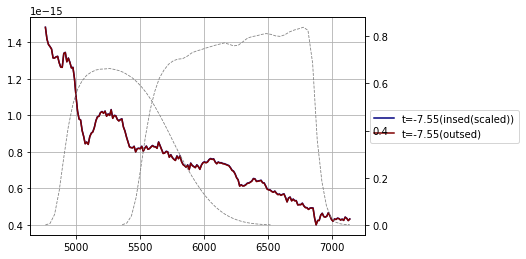

Phase= -7.3371247826
Phase 53677.22 out of data range [53681.08,53756.07].
Phase 53677.22 out of data range [53681.08,53756.07].
Phase 53677.22 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = -7.3371247826
Phot_at_p:
    Phase     Filter      Mag            MagErr      sortid
------------- ------ ------------- ----------------- ------
-7.3371247826 CSP-BS 16.4969123746 0.000463408464974      0
-7.3371247826 CSP-gS 16.4264306362 0.000350743059599      1
-7.3371247826 CSP-VS 16.5254243328 0.000291464203021      2
-7.3371247826 CSP-rS 16.5411447985 0.000241075248752      3
modelmag0 [ 16.58176291  16.52127629  16.64760081  16.62732334]
phot_at_p['Mag'] - modelmag0: [-0.08485054 -0.09484565 -0.12217647 -0.08617854]
modelmag: [ 16.46018078  16.39811415  16.5222

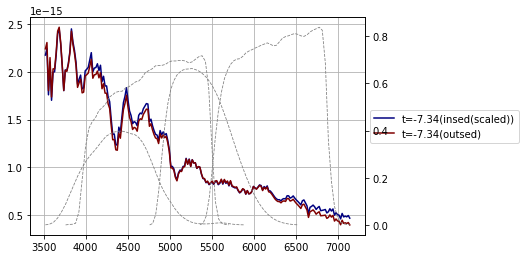

Phase= -6.56718025809
Phase 53678.0 out of data range [53681.08,53756.07].
Phase 53678.0 out of data range [53681.08,53756.07].
Phase 53678.0 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS']
efflam =  [ 5389.26524088  6239.34112913]
Phase = -6.56718025809
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-6.56718025809 CSP-VS 16.4082688367 0.000323573266201      0
-6.56718025809 CSP-rS  16.420437248 0.000267282104255      1
modelmag0 [ 16.37646915  16.36719402]
phot_at_p['Mag'] - modelmag0: [ 0.03179968  0.05324323]
modelmag: [ 16.4088065   16.39847727]
phot_at_p['Mag'] - modelmag: [-0.00053766  0.02195997]
diff/err: 82.1602860258
iter = 0
modelmag: [ 16.40750081  16.41855076]
phot_at_p['Mag'] - modelmag: [ 0.00076803  0.00188649]
diff/err: 7.058033803

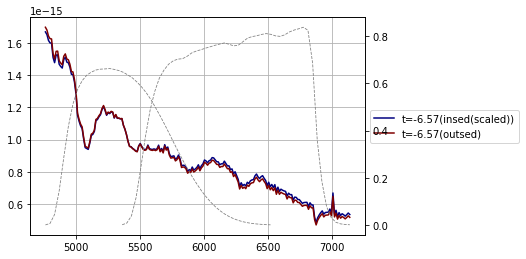

Phase= -6.56718025809
Phase 53678.0 out of data range [53681.08,53756.07].
Phase 53678.0 out of data range [53681.08,53756.07].
Phase 53678.0 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = -6.56718025809
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-6.56718025809 CSP-gS  16.313157911  0.00038386436727      0
-6.56718025809 CSP-VS 16.4082688367 0.000323573266201      1
-6.56718025809 CSP-rS  16.420437248 0.000267282104255      2
-6.56718025809 CSP-iS 16.6407361893 0.000243409009027      3
modelmag0 [ 16.28437034  16.41159398  16.34336417  16.55469756]
phot_at_p['Mag'] - modelmag0: [ 0.02878757 -0.00332514  0.07707308  0.08603862]
modelmag: [ 16.28409063  16.41030695  16

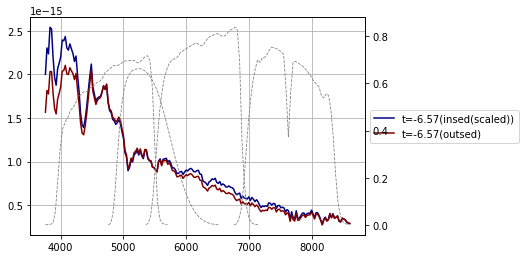

Phase= -6.31053208325
Phase 53678.26 out of data range [53681.08,53756.07].
Phase 53678.26 out of data range [53681.08,53756.07].
Phase 53678.26 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = -6.31053208325
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-6.31053208325 CSP-BS 16.3497586069 0.000505789672405      0
-6.31053208325 CSP-gS 16.2770853751 0.000374894533242      1
-6.31053208325 CSP-VS 16.3707307287 0.000319923157298      2
-6.31053208325 CSP-rS 16.3818336242 0.000263957974732      3
modelmag0 [ 16.40813094  16.34401987  16.4609958   16.43853785]
phot_at_p['Mag'] - modelmag0: [-0.05837233 -0.0669345  -0.09026507 -0.05670423]
modelmag: [ 16.32387271  16.25671069 

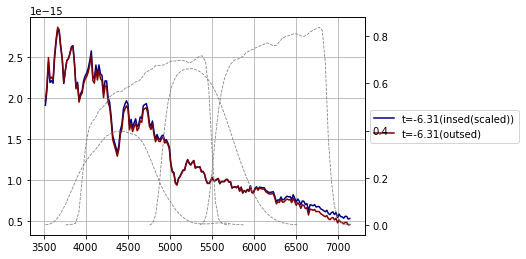

Phase= -5.58007189333
Phase 53679.0 out of data range [53681.08,53756.07].
Phase 53679.0 out of data range [53681.08,53756.07].
Phase 53679.0 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = -5.58007189333
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-5.58007189333 CSP-BS 16.2550707283 0.000424591173589      0
-5.58007189333 CSP-gS 16.1798365827  0.00030741556026      1
-5.58007189333 CSP-VS 16.2688241214 0.000276591309866      2
-5.58007189333 CSP-rS 16.2772887002 0.000226809907366      3
-5.58007189333 CSP-iS 16.5000574153 0.000204180011854      4
modelmag0 [ 16.25388741  16.17144803  16.28887556  16.30794202  16.48436236]
phot_at_p['Mag'] - modelmag0: [ 

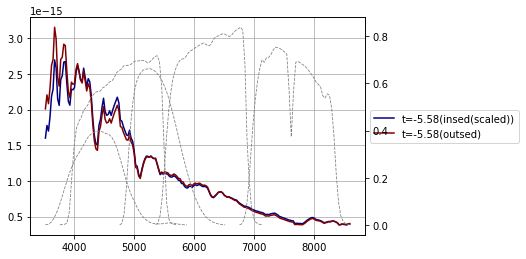

Phase= -5.58007189333
Phase 53679.0 out of data range [53681.08,53756.07].
Phase 53679.0 out of data range [53681.08,53756.07].
Phase 53679.0 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = -5.58007189333
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-5.58007189333 CSP-BS 16.2550707283 0.000424591173589      0
-5.58007189333 CSP-gS 16.1798365827  0.00030741556026      1
-5.58007189333 CSP-VS 16.2688241214 0.000276591309866      2
-5.58007189333 CSP-rS 16.2772887002 0.000226809907366      3
-5.58007189333 CSP-iS 16.5000574153 0.000204180011854      4
modelmag0 [-21.24081034 -21.361529   -21.30428042 -21.32910117 -21.13667609]
phot_at_p['Mag'] - modelmag0: [ 

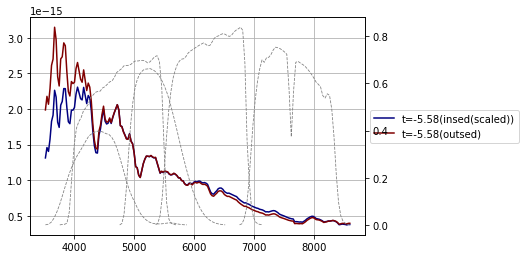

Phase= -5.36290805309
Phase 53679.22 out of data range [53681.08,53756.07].
Phase 53679.22 out of data range [53681.08,53756.07].
Phase 53679.22 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = -5.36290805309
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-5.36290805309 CSP-BS 16.2287742086 0.000389368901109      0
-5.36290805309 CSP-gS 16.1526176209 0.000279318417446      1
-5.36290805309 CSP-VS 16.2400739161 0.000256722707587      2
-5.36290805309 CSP-rS 16.2478782137 0.000209905159736      3
modelmag0 [ 16.55511026  16.48655272  16.59322153  16.53742197]
phot_at_p['Mag'] - modelmag0: [-0.32633605 -0.3339351  -0.35314762 -0.28954376]
modelmag: [ 16.20049682  16.13397622 

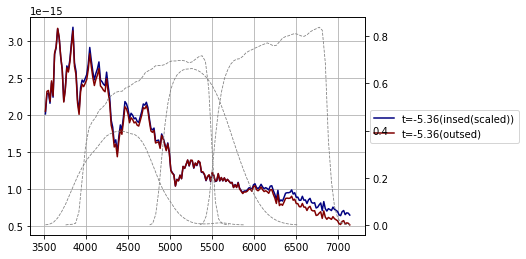

Phase= -4.59296352858
Phase 53680.0 out of data range [53681.08,53756.07].
Phase 53680.0 out of data range [53681.08,53756.07].
Phase 53680.0 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-VS', u'CSP-Jd', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-rS', 'CSP-iS']
efflam =  [ 6239.34112913  7630.76341788]
Phase = -4.59296352858
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-4.59296352858 CSP-rS 16.1504407927 0.000141096064105      0
-4.59296352858 CSP-iS 16.3750583553 0.000128380519047      1
modelmag0 [ 16.14982764  16.37899607]
phot_at_p['Mag'] - modelmag0: [ 0.00061316 -0.00393772]
modelmag: [ 16.15092571  16.38106694]
phot_at_p['Mag'] - modelmag: [-0.00048492 -0.00600858]
diff/err: 46.8029238767
iter = 0
modelmag: [ 16.15091071  16.37537032]
phot_at_p['Mag'] - modelmag: [-0.00046992 -0.00031196]
diff/err: 3.330479185

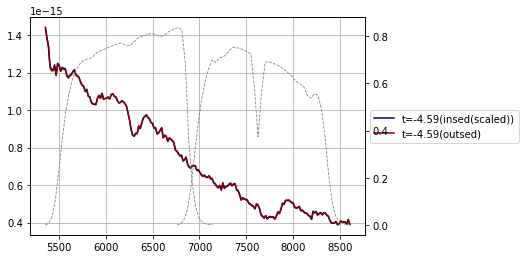

Phase= -4.59296352858
Phase 53680.0 out of data range [53681.08,53756.07].
Phase 53680.0 out of data range [53681.08,53756.07].
Phase 53680.0 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = -4.59296352858
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-4.59296352858 CSP-gS 16.0630525825 0.000172228161273      0
-4.59296352858 CSP-VS 16.1444736772 0.000175480043409      1
-4.59296352858 CSP-rS 16.1504407927 0.000141096064105      2
-4.59296352858 CSP-iS 16.3750583553 0.000128380519047      3
modelmag0 [ 16.10128013  16.17873449  16.14873035  16.37269663]
phot_at_p['Mag'] - modelmag0: [-0.03822754 -0.03426081  0.00171045  0.00236172]
modelmag: [ 16.0683346   16.14327748  16

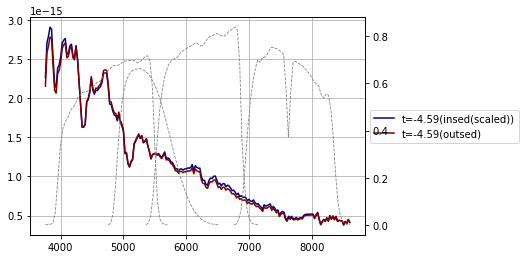

Phase= -4.37579968833
Phase 53680.22 out of data range [53681.08,53756.07].
Phase 53680.22 out of data range [53681.08,53756.07].
Phase 53680.22 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = -4.37579968833
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-4.37579968833 CSP-BS 16.1211457194 0.000213969568295      0
-4.37579968833 CSP-gS 16.0398642187 0.000143797749567      1
-4.37579968833 CSP-VS  16.119393944 0.000152382827192      2
-4.37579968833 CSP-rS 16.1249903635 0.000121643717685      3
modelmag0 [ 16.02412259  15.94232349  16.02731219  15.98881784]
phot_at_p['Mag'] - modelmag0: [ 0.09702313  0.09754073  0.09208175  0.13617252]
modelmag: [ 16.12307952  16.03774754 

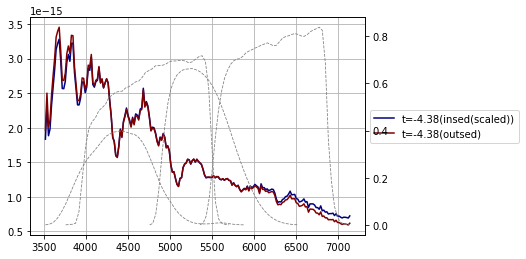

Phase= -4.29683101915
Phase 53680.3 out of data range [53681.08,53756.07].
Phase 53680.3 out of data range [53681.08,53756.07].
Phase 53680.3 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-VS', u'CSP-Jd', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-rS', 'CSP-iS']
efflam =  [ 6239.34112913  7630.76341788]
Phase = -4.29683101915
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-4.29683101915 CSP-rS 16.1159653229 0.000114775672142      0
-4.29683101915 CSP-iS 16.3410120007 0.000105123015669      1
modelmag0 [-27.69398488 -27.47140211]
phot_at_p['Mag'] - modelmag0: [ 43.80995021  43.81241411]
modelmag: [ 16.11474576  16.33851248]
phot_at_p['Mag'] - modelmag: [ 0.00121956  0.00249953]
diff/err: 23.7771455919
iter = 0
modelmag: [ 16.11580896  16.34093102]
phot_at_p['Mag'] - modelmag: [  1.56358174e-04   8.09807128e-05]
diff/err:

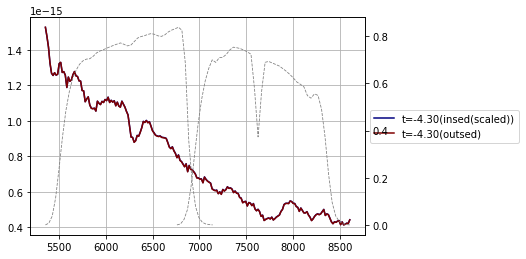

Phase= -3.60585516382
Phase 53681.0 out of data range [53681.08,53756.07].
Phase 53681.0 out of data range [53681.08,53756.07].
Phase 53681.0 out of data range [53681.08,53743.07].
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-VS', u'CSP-Jd', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-rS', 'CSP-iS']
efflam =  [ 6239.34112913  7630.76341788]
Phase = -3.60585516382
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-3.60585516382 CSP-rS 16.0423254489 6.25703850831e-05      0
-3.60585516382 CSP-iS 16.2681344276 5.87148231634e-05      1
modelmag0 [ 16.04788241  16.28955646]
phot_at_p['Mag'] - modelmag0: [-0.00555697 -0.02142204]
modelmag: [ 16.04210839  16.28598032]
phot_at_p['Mag'] - modelmag: [ 0.00021706 -0.01784589]
diff/err: 303.94188331
iter = 0
modelmag: [ 16.04373533  16.26914231]
phot_at_p['Mag'] - modelmag: [-0.00140989 -0.00100789]
diff/err: 22.532788945

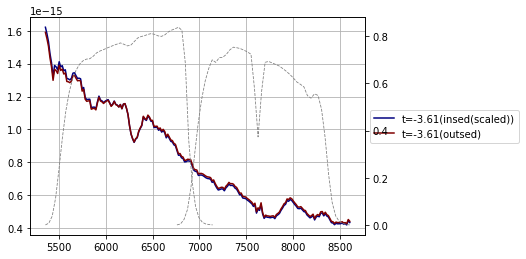

Phase= -3.40843349087
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-VS', u'CSP-Jd', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-rS', 'CSP-iS']
efflam =  [ 6239.34112913  7630.76341788]
Phase = -3.40843349087
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-3.40843349087 CSP-rS 16.0230611569  5.0975499062e-05      0
-3.40843349087 CSP-iS 16.2490235511 4.83496175563e-05      1
modelmag0 [-24.48430921 -24.24296198]
phot_at_p['Mag'] - modelmag0: [ 40.50737037  40.49198554]
modelmag: [ 16.02409272  16.26180687]
phot_at_p['Mag'] - modelmag: [-0.00103156 -0.01278332]
diff/err: 264.393445687
iter = 0
modelmag: [ 16.02404729  16.24968857]
phot_at_p['Mag'] - modelmag: [-0.00098614 -0.00066502]
diff/err: 19.3452823426
iter = 1
modelmag: [ 16.02307412  16.24901378]
phot_at_p['Mag'] - modelmag: [ -1.29664333e-05   9.76776302e-06]
diff/err: 0.254365990083
iter = 2


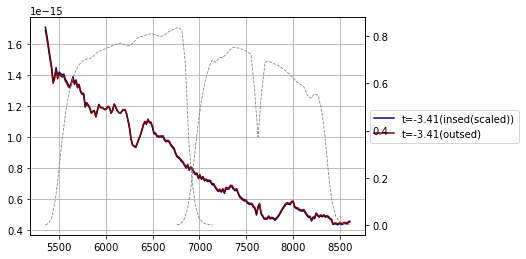

Phase= -3.37882023992
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = -3.37882023992
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-3.37882023992 CSP-BS 16.0339710601 8.00740005282e-05      0
-3.37882023992 CSP-gS 15.9459591219 4.67006541567e-05      1
-3.37882023992 CSP-VS 16.0155112811 6.52169869774e-05      2
-3.37882023992 CSP-rS 16.0202397904 4.93797285808e-05      3
modelmag0 [ 17.23859583  17.15451634  17.24522067  17.22782075]
phot_at_p['Mag'] - modelmag0: [-1.20462477 -1.20855722 -1.22970939 -1.20758095]
modelmag: [ 16.01398416  15.92959245  16.01683049  15.99526715]
phot_at_p['Mag'] - modelmag: [ 0.0199869   0.01636667 -0.00131921  0.02497264]
diff/err: 505.726646256
iter = 0
modelmag: [ 16.02632884

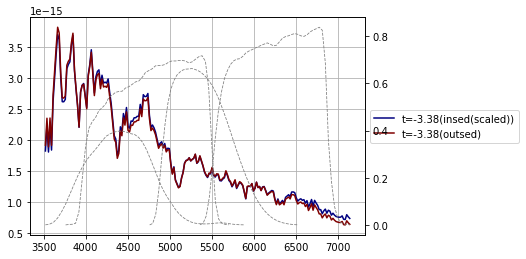

Phase= -2.42132512612
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = -2.42132512612
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-2.42132512612 CSP-BS 15.9719347127 2.34426886583e-05      0
-2.42132512612 CSP-gS 15.8759777136 1.21297540923e-05      1
-2.42132512612 CSP-VS 15.9334413413 2.35625186162e-05      2
-2.42132512612 CSP-rS 15.9384855792 1.77369690062e-05      3
modelmag0 [ 17.31408266  17.22769303  17.31094951  17.26702983]
phot_at_p['Mag'] - modelmag0: [-1.34214795 -1.35171532 -1.37750817 -1.32854425]
modelmag: [ 15.9363584   15.84792051  15.9314964   15.89606292]
phot_at_p['Mag'] - modelmag: [ 0.03557631  0.02805721  0.00194494  0.04242266]
diff/err: 2391.76512092
iter = 0
modelmag: [ 15.96139278

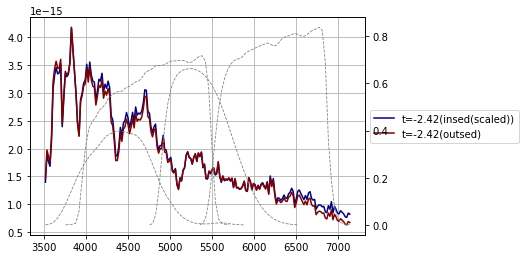

Phase= -2.42132512612
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-VS', u'CSP-Jd', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-rS', 'CSP-iS']
efflam =  [ 6239.34112913  7630.76341788]
Phase = -2.42132512612
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-2.42132512612 CSP-rS 15.9384855792 1.77369690062e-05      0
-2.42132512612 CSP-iS 16.1647461017 1.88999288113e-05      1
modelmag0 [-24.62127363 -24.42537317]
phot_at_p['Mag'] - modelmag0: [ 40.55975921  40.59011927]
modelmag: [ 15.93720786  16.13823781]
phot_at_p['Mag'] - modelmag: [ 0.00127772  0.02650829]
diff/err: 1402.56033417
iter = 0
modelmag: [ 15.93648093  16.1633458 ]
phot_at_p['Mag'] - modelmag: [ 0.00200465  0.0014003 ]
diff/err: 113.020940318
iter = 1
modelmag: [ 15.93845537  16.16476157]
phot_at_p['Mag'] - modelmag: [  3.02116431e-05  -1.54691145e-05]
diff/err: 1.70331487273
iter = 2
modelmag:

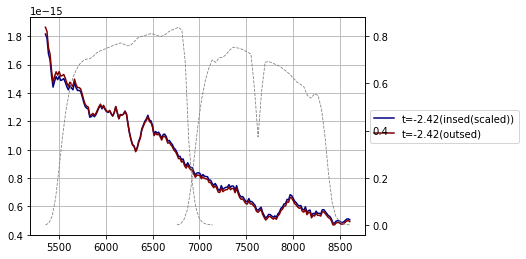

Phase= -1.41447459406
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = -1.41447459406
Phot_at_p:
    Phase      Filter      Mag            MagErr      sortid
-------------- ------ ------------- ----------------- ------
-1.41447459406 CSP-BS 15.9297725508  1.5363170548e-05      0
-1.41447459406 CSP-gS 15.8238671746 1.46837273558e-05      1
-1.41447459406 CSP-VS 15.8651302331 1.61622264142e-05      2
-1.41447459406 CSP-rS 15.8712111481 1.67901915009e-05      3
modelmag0 [ 16.54607707  16.43097544  16.48497086  16.45057824]
phot_at_p['Mag'] - modelmag0: [-0.61630452 -0.60710827 -0.61984063 -0.57936709]
modelmag: [ 15.93337711  15.82272073  15.87737221  15.82690732]
phot_at_p['Mag'] - modelmag: [-0.00360456  0.00114645 -0.01224198  0.04430383]
diff/err: 2638.67330718
iter = 0
modelmag: [ 15.9185422 

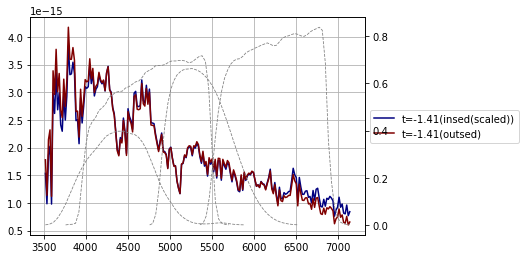

Phase= 3.30390338947
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS']
efflam =  [ 5389.26524088  6239.34112913]
Phase = 3.30390338947
Phot_at_p:
    Phase     Filter      Mag            MagErr      sortid
------------- ------ ------------- ----------------- ------
3.30390338947 CSP-VS 15.7420390749 3.04753330993e-05      0
3.30390338947 CSP-rS 15.7151933965 2.30223400891e-05      1
modelmag0 [ 15.7980322   15.70273259]
phot_at_p['Mag'] - modelmag0: [-0.05599312  0.01246081]
modelmag: [ 15.74089954  15.64772734]
phot_at_p['Mag'] - modelmag: [ 0.00113953  0.06746606]
diff/err: 2930.46053419
iter = 0
modelmag: [ 15.74271492  15.70937627]
phot_at_p['Mag'] - modelmag: [-0.00067584  0.00581712]
diff/err: 252.672957921
iter = 1
modelmag: [ 15.74208516  15.71460565]
phot_at_p['Mag'] - modelmag: [ -4.60856957e-05   5.87743379e-04]
diff/err: 25.5292631698
iter = 2
modelmag: [ 15.74

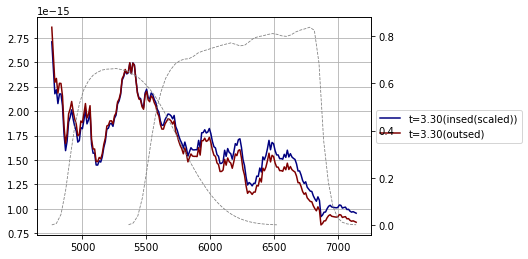

Phase= 12.1878786723
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS']
efflam =  [ 5389.26524088  6239.34112913]
Phase = 12.1878786723
Phot_at_p:
    Phase     Filter      Mag            MagErr      sortid
------------- ------ ------------- ----------------- ------
12.1878786723 CSP-VS 16.1385004308 2.29732842608e-05      0
12.1878786723 CSP-rS 15.8113011724 1.47561236727e-05      1
modelmag0 [ 16.1833387   15.79969206]
phot_at_p['Mag'] - modelmag0: [-0.04483827  0.01160911]
modelmag: [ 16.14208143  15.75835913]
phot_at_p['Mag'] - modelmag: [-0.003581    0.05294204]
diff/err: 3587.80149142
iter = 0
modelmag: [ 16.14257052  15.80784485]
phot_at_p['Mag'] - modelmag: [-0.00407009  0.00345632]
diff/err: 234.229813078
iter = 1
modelmag: [ 16.13904103  15.8108778 ]
phot_at_p['Mag'] - modelmag: [-0.00054059  0.00042337]
diff/err: 28.6914374926
iter = 2
modelmag: [ 16.13856933  15

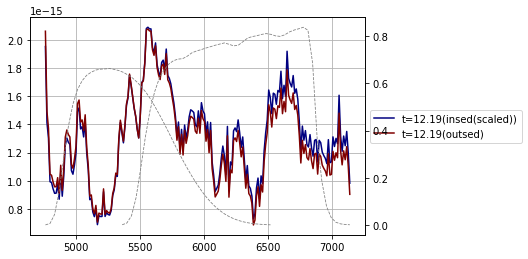

Phase= 14.1620954018
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = 14.1620954018
Phot_at_p:
    Phase     Filter      Mag            MagErr      sortid
------------- ------ ------------- ----------------- ------
14.1620954018 CSP-BS 17.4112491849 4.03312874933e-05      0
14.1620954018 CSP-gS 16.9467692847 1.32224234795e-05      1
14.1620954018 CSP-VS 16.3155971357 2.05121879454e-05      2
14.1620954018 CSP-rS 15.9174859626 8.42064699591e-06      3
14.1620954018 CSP-iS 15.8727316267    1.49807755e-05      4
modelmag0 [ 17.39818644  16.95000818  16.35210821  15.92325538  15.87035155]
phot_at_p['Mag'] - modelmag0: [ 0.01306275 -0.0032389  -0.03651107 -0.00576942  0.00238008]
modelmag: [ 17.34849442  16.90009619  16.31141667  15.89048559  15.82123006]
phot_at_p['Mag'] - modelmag: [ 

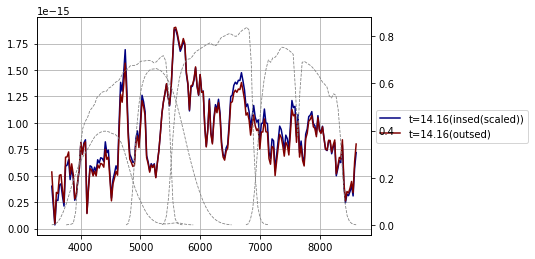

Phase= 14.379259242
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = 14.379259242
Phot_at_p:
   Phase     Filter      Mag            MagErr      sortid
------------ ------ ------------- ----------------- ------
14.379259242 CSP-BS 17.4416582232 4.29804934061e-05      0
14.379259242 CSP-gS 16.9748253448 1.43181957504e-05      1
14.379259242 CSP-VS 16.3352950606 2.16149016516e-05      2
14.379259242 CSP-rS 15.9301521495 9.13086415744e-06      3
modelmag0 [ 17.85136552  17.35484141  16.70791802  16.27554038]
phot_at_p['Mag'] - modelmag0: [-0.40970729 -0.38001607 -0.37262296 -0.34538823]
modelmag: [ 17.4891021   16.98626208  16.33537898  15.90157269]
phot_at_p['Mag'] - modelmag: [ -4.74438797e-02  -1.14367343e-02  -8.39190148e-05   2.85794604e-02]
diff/err: 3129.98418122
iter = 0
modelmag: [ 17.4436

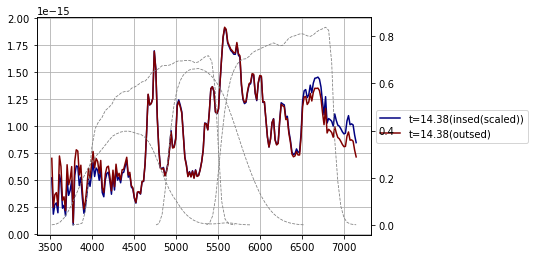

Phase= 20.2821672633
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913]
Phase = 20.2821672633
Phot_at_p:
    Phase     Filter      Mag            MagErr      sortid
------------- ------ ------------- ----------------- ------
20.2821672633 CSP-BS 18.0902585682 0.000169080823726      0
20.2821672633 CSP-gS 17.5811291111 5.43214578446e-05      1
20.2821672633 CSP-VS 16.8213919089 6.25094149453e-05      2
20.2821672633 CSP-rS 16.3123852781 5.54639356292e-05      3
modelmag0 [ 18.3320897   17.79865679  17.0417      16.48656262]
phot_at_p['Mag'] - modelmag0: [-0.24183113 -0.21752768 -0.22030809 -0.17417734]
modelmag: [ 18.13498564  17.59071469  16.82643165  16.27260667]
phot_at_p['Mag'] - modelmag: [-0.04472707 -0.00958558 -0.00503974  0.03977861]
diff/err: 717.197717689
iter = 0
modelmag: [ 18.09192689  17.572

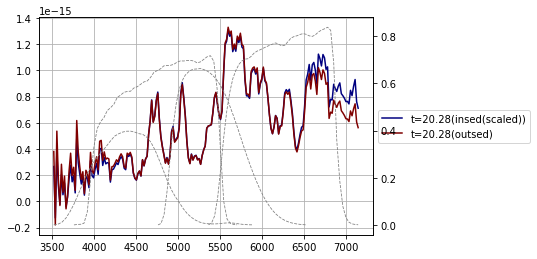

Phase= 21.8615406469
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 5389.26524088  6239.34112913  7630.76341788]
Phase = 21.8615406469
Phot_at_p:
    Phase     Filter      Mag            MagErr      sortid
------------- ------ ------------- ----------------- ------
21.8615406469 CSP-VS 16.9245688095 8.63071827216e-05      0
21.8615406469 CSP-rS 16.4118135657 8.18397949699e-05      1
21.8615406469 CSP-iS 16.2422511988 7.93471007398e-05      2
modelmag0 [-17.19897885 -17.75709505 -17.93795702]
phot_at_p['Mag'] - modelmag0: [ 34.12354766  34.16890862  34.18020822]
modelmag: [ 16.92300706  16.36650755  16.18385448]
phot_at_p['Mag'] - modelmag: [ 0.00156175  0.04530601  0.05839671]
diff/err: 735.965321929
iter = 0
modelmag: [ 16.92970972  16.40834821  16.24073325]
phot_at_p['Mag'] - modelmag: [-0.00514091  0.00346536  0.00151794]
diff/err: 59.5652321809
iter = 1
m

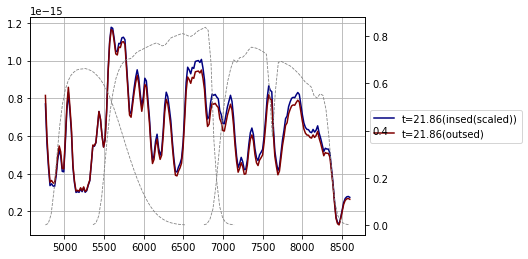

Phase= 23.0460706846
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = 23.0460706846
Phot_at_p:
    Phase     Filter      Mag            MagErr      sortid
------------- ------ ------------- ----------------- ------
23.0460706846 CSP-BS 18.2745318832 0.000316401442595      0
23.0460706846 CSP-gS 17.7697062286  0.00013802803365      1
23.0460706846 CSP-VS 16.9929531672 0.000128358330981      2
23.0460706846 CSP-rS 16.4800385254  0.00011299741402      3
23.0460706846 CSP-iS 16.3029115309 0.000106663538146      4
modelmag0 [ 18.29833482  17.75231956  17.01205461  16.47724067  16.2942497 ]
phot_at_p['Mag'] - modelmag0: [-0.02380294  0.01738667 -0.01910145  0.00279786  0.00866183]
modelmag: [ 18.27945962  17.73365959  16.99145367  16.45793801  16.27500252]
phot_at_p['Mag'] - modelmag: [-

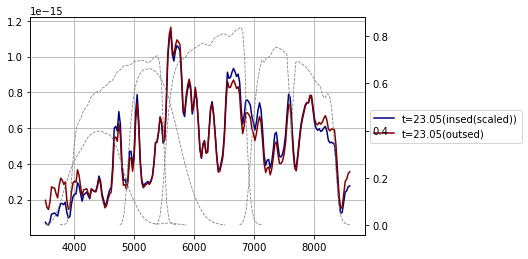

Phase= 23.1941369393
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS']
efflam =  [ 5389.26524088  6239.34112913]
Phase = 23.1941369393
Phot_at_p:
    Phase     Filter      Mag            MagErr      sortid
------------- ------ ------------- ----------------- ------
23.1941369393 CSP-VS 17.0010022052 0.000133389058454      0
23.1941369393 CSP-rS 16.4881374458 0.000116248460696      1
modelmag0 [ 17.18828244  16.61575526]
phot_at_p['Mag'] - modelmag0: [-0.18728023 -0.12761781]
modelmag: [ 17.00374447  16.42694678]
phot_at_p['Mag'] - modelmag: [-0.00274226  0.06119066]
diff/err: 526.378268501
iter = 0
modelmag: [ 17.00941974  16.48415143]
phot_at_p['Mag'] - modelmag: [-0.00841753  0.00398602]
diff/err: 63.1051059617
iter = 1
modelmag: [ 17.00260003  16.48745598]
phot_at_p['Mag'] - modelmag: [-0.00159783  0.00068147]
diff/err: 11.9786987628
iter = 2
modelmag: [ 17.00129395  16

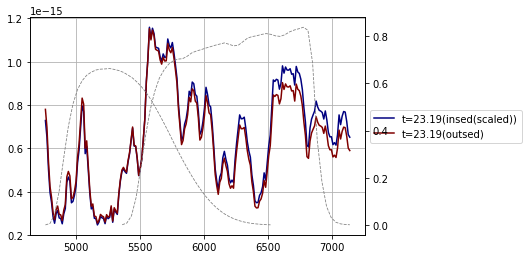

Phase= 23.342203194
Bands are out of range [u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-BS', 'CSP-gS', 'CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 4405.52523159  4794.04150564  5389.26524088  6239.34112913  7630.76341788]
Phase = 23.342203194
Phot_at_p:
   Phase     Filter      Mag            MagErr      sortid
------------ ------ ------------- ----------------- ------
23.342203194 CSP-BS 18.2898714446  0.00033641818622      0
23.342203194 CSP-gS 17.7871565281 0.000153994581965      1
23.342203194 CSP-VS 17.0089485048 0.000138055970431      2
23.342203194 CSP-rS 16.4961402267 0.000119126554997      3
23.342203194 CSP-iS 16.3178456948 0.000112359585788      4
modelmag0 [-19.1195926  -19.69500551 -20.47093726 -21.03227022 -21.20410739]
phot_at_p['Mag'] - modelmag0: [ 37.40946404  37.48216203  37.47988577  37.52841044  37.52195308]
modelmag: [ 18.36053553  17.78533581  17.00726438  16.44743962  16.27573343]
phot_at_p['Mag'] - modelmag: [-0.07

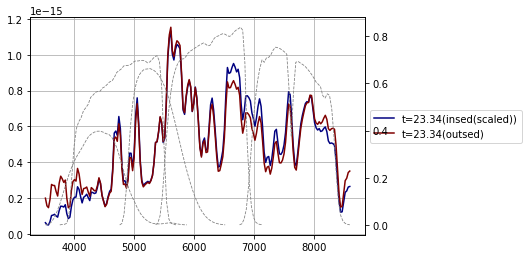

Phase= 26.0073957789
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS']
efflam =  [ 5389.26524088  6239.34112913]
Phase 26.01 out of range: [-15, 25]
Phase= 27.1129571474
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-iS', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS']
efflam =  [ 5389.26524088  6239.34112913]
Phase 27.11 out of range: [-15, 25]
Phase= 36.8655877912
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS', 'CSP-iS']
efflam =  [ 5389.26524088  6239.34112913  7630.76341788]
Phase 36.87 out of range: [-15, 25]
Phase= 38.8398045207
Bands are out of range [u'CSP-BS', u'CSP-YS', u'CSP-uS', u'CSP-Jd', u'CSP-HS', u'CSP-gS', u'CSP-Yd', u'CSP-JS', u'CSP-Hd']
Filters:  ['CSP-VS', 'CSP-rS', 'CSP-iS']
efflam = 

In [21]:
for s in spectra.iterrows():
   
    spectrum = s[1]
      
    phase = (spectrum['time']-peakmjd)/(1.+ z)
    print "Phase=",phase
    
    mags = []
    magerr = []
    goodfilts = []

    for i,f in enumerate(filters):
#             print peakmjd
        mjd = phase*(1.+z)+peakmjd
        mag = meanlc[i](mjd)
        merr = meanlc_err[i](mjd)
        mags.append(mag)
        magerr.append(merr)
        fminmjd = np.min(sn['MJD'][sn['Filter']==f])
        fmaxmjd = np.max(sn['MJD'][sn['Filter']==f])        
        
        if mjd < fminmjd  or mjd > fmaxmjd:
            print "Phase {} out of data range [{},{}].".format(mjd,fminmjd,fmaxmjd)
            goodfilts.append(False)
        else:
            goodfilts.append(True)
    goodfilts = np.array(goodfilts)

    phases = [phase]*len(filters)
    data_table = zip(mags,magerr,filters,phases)      
    synlc = Table(rows = data_table,names=('Mag','MagErr','Filter','Phase'),dtype=('f8', 'f8', 'S30','f8'))
    synlc_good = synlc[goodfilts]

    if len(synlc_good) < 2:
        print "Number of available bands is < 2. Skip this phase."
        continue

    nrepeat = 5
    phase = np.linspace(-50.,50.,nrepeat)

    sdata = pd.DataFrame(spectrum['data'])

    wave = np.array(sdata[0].astype(float))
    flux = np.atleast_2d(sdata[1].astype(float))

#     plt.plot(wave,flux.ravel())

    newsource = sncosmo.TimeSeriesSource(phase,wave,np.repeat(flux,nrepeat,axis=0))
    newsed_at_p = sncosmo.Model(newsource)
    
    excl_fs = []
    for f in filters:
        band = sncosmo.get_bandpass(f)
        minwave = band.minwave() 
        maxwave = band.maxwave()
        if minwave < wave.min() or maxwave > wave.max():
            excl_fs.append(f)
    print "Bands are out of range",excl_fs

    idx = np.array([(x in np.array(excl_fs)) for x in synlc_good['Filter']])
    
    inlc = synlc_good[~idx]
    
    if len(set(inlc['Filter']))<2:
        print "Number of in-range filters is < 2. Skip this phase."
        continue
        
    sedfit.mangle.manglespec(inlc,insed =newsed_at_p, redshift=z,insed_is_rest=False)

    plt.show()